# Gradient Symbolic Computation

see `TPR_example.ipynb` for details about the TP representation and one possible empirical phenomenon, that can be handled with GSC.

In [1]:
# Imports
from src.classes.Grammar import Grammar
from src.gsc.gsc_network import Net
import pandas as pd
import torch
# Set seed for reproducibility
torch.manual_seed(123)

## Grammar and Harmonic Constraints

In [2]:
# Fillers and Roles
fillers = ["bh", "b", "u", "d", "dh"]
# The simplest possible roles: s1 = first position in the word, s2 = second position ....
roles = ["s1", "s2", "s3","s4"]

"""similarities = torch.tensor([[1, 0.75, 0, 0, 0],
                             [0.75, 1, 0, 0, 0],
                             [0, 0, 1, 0, 0],
                             [0, 0, 0, 1, 0.75],
                             [0, 0, 0, 0.75, 1]])"""

# Build Grammar
G = Grammar(fillers, roles, emtpyFiller="#")
#G = Grammar(fillers, roles, emtpyFiller="_", fillerSimilarities=similarities)

Buil Filler Matrix
Representations built after 182 attempts

Build role Matrix
Representations built after 187 attempts



__Single Constituents Harmony__

The following code sets the harmony values for single bindings. 
For instance the constraint `("b/s1", 2)` means that the segment "b" in first position ("s1") improves the general harmony by 2. 

There will be *Harmony crosstalk* if the vector representing those bindings are not independent (dot product == 0). Let's suppose that the vector representing "b/s1" has a non-null dotproduct with the vector representing "bh/s1". Then "bh/s1" will also improve its harmony by a factor $H_{b/s1} \times (b/s1 \cdot bh/s1)$


In [3]:
# Single Harmony constraints
cons = [("u/s2", 3)] # Prefer u in the second position (nucleus)
G.update_Hc(cons)

__Pairwise Harmony__

These constraints provide a way to declare Harmonic Constraints in the GSC. 
Ex.:

`("u/s2" "d/s3", -3)` means that the co-occurence of "u" in the secondo position and "d" in the third position makes the total Harmony decrease by -3 points. This  (indirectly) implement the preference for "dh" in "s3".


In [4]:
# Pairwise Harmony
# Matrix dim: (nF, nR, nF, nR)
cons = [("b/s1", "dh/s3", 3), ("dh/s3", "dh/s4", -7),("b/s1","u/s2",5),("b/s1", "d/s3", -2), ("dh/s3", "d/s4", -7), ("d/s3", "d/s4", 5), ("bh/s1", "d/s3", 7), ("bh/s1", "d/s3",7)]
G.update_Hcc(cons)

### Single binding Harmonies:

In [5]:
harmonies = G.Hc.numpy()
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3,s4
bh,0.0,0.0,0.0,0.0
b,0.0,0.0,0.0,0.0
u,0.0,3.0,0.0,0.0
d,0.0,0.0,0.0,0.0
dh,0.0,0.0,0.0,0.0
#,0.0,0.0,0.0,0.0


In [6]:
import seaborn as sns

<AxesSubplot:>

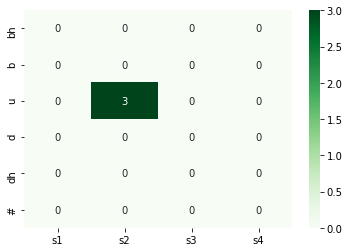

In [7]:
sns.heatmap(harmonies, annot=True, cmap="Greens")

### Pairwise Harmonies:

In [8]:
# Harmonies for the binding : b/s1
harmonies = G.Hcc.numpy()[:,:,1,0]
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3,s4
bh,0.0,0.0,0.0,0.0
b,0.0,0.0,0.0,0.0
u,0.0,5.0,0.0,0.0
d,0.0,0.0,-2.0,0.0
dh,0.0,0.0,3.0,0.0
#,0.0,0.0,0.0,0.0


<AxesSubplot:>

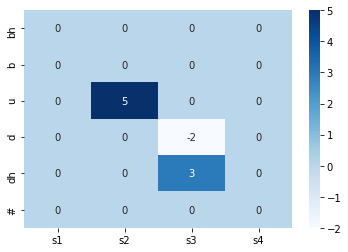

In [9]:
sns.heatmap(harmonies, annot=True, cmap="Blues")

The preceding matrix is the matrix for "b" in first sequential position, the binding "b/s1". 
What the matrix is representing is the improvement in Harmony caused by the co-occurence of ("b/s1", "u/s2") and/or ("b/s1, "dh/s3")

## GSC Net

In [10]:
# Custom settings (these substitute the hard-coded settings)

# ---------------------------------------
#           GSC NET
# ---------------------------------------

custom_settings = {"epochs": 5,
                   "tgtStd": 0.00125,
                   "emaFactor": 0.01,
                   "emaSpeedTol": 0.002,
                   "dt": 1e-5,
                   "TDecayRate": 0.05,
                   "TInit" : 1e-5,
                   "lambdaDecayRate": 0.5,
                   "lambdaMin": 0.01,
                   "maxSteps": 10000,
                   "printInterval": 5000,
                   'bowl_center': 0.4,
                   'beta_min_offset': 2,
                   'q_init': 16}
# Initialize
N = Net(G, custom_settings=custom_settings, extData_path="data/inp_pandas.csv")


Input processed: b-bh-u-dh-u

Input processed: b-u-dh-#

Input processed: b-bh-u-dh-d-#

Value for Q set to 28.305154814931683
LAMBDA RECOMMENDED: 0.006197592030312094, ACTUAL LAMBDA = 0.011387


If you want to change to the recommended Lambda value press 'y', else any other key: y


T RECOMMENDED: 2.58157217593323e-05, ACTUAL T = 1e-05


If you want to change to the recommended value press 'y', else any other key: 


The external data were provided in form of a simple csv file and were imported in the GSCNet using `pandas`:

In [11]:
# EXTERNAL INPUTS 

# Read dataframe
inputs = pd.read_csv("data/inp_pandas.csv", sep=",")
inputNames = []
nStimuli = len(inputs['id'].unique())

# Initialize stimuli tensor
stimuli = torch.zeros((nStimuli, len(fillers) + 1, len(roles)))

# Loop over the single inputs as whole
for idx, i in enumerate(inputs['id'].unique()):
    inp_string = ""
    stimulus = inputs[inputs.id == i].to_numpy()[:, 1:]

    # Loop over the fillers in a given input
    for filler in stimulus:
        fidx = N.filler2index[filler[0]]
        inp_string += filler[0] + "-"
        for roledix in range(N.grammar.bind.nR):
            stimuli[idx, fidx, roledix] = filler[roledix+1]
    print(f"Input processed: {inp_string[:-1]}\n")
    # Store the names for later plotting
    inputNames.append(inp_string[:-1])

Input processed: b-bh-u-dh-u

Input processed: b-u-dh-#

Input processed: b-bh-u-dh-d-#



+ First inp: gradient blend for the root *{b, bh}udu*:
+ Second inp: discrete *budh*
+ Third inp: gradient blend *{b,bh}u{d,dh}*

<small>'#' stands for an empty position</small>

     s1   s2   s3   s4
bh  0.7  0.0  0.0  0.0
b   0.8  0.0  0.0  0.0
u   0.0  0.0  0.0  1.0
d   0.0  0.0  0.0  0.0
dh  0.0  0.0  1.0  0.0
#   0.0  0.0  0.0  0.0


<AxesSubplot:>

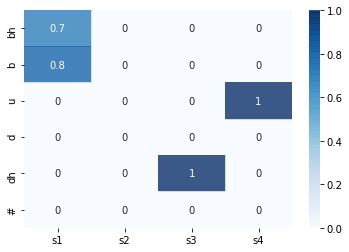

In [12]:
b_bh_ud = N.stimuli[0,:,:].numpy()
b_bh_ud = pd.DataFrame(b_bh_ud, columns=roles, index=fillers)
print(b_bh_ud)
sns.heatmap(b_bh_ud, alpha=.8, cmap="Blues", annot=True)

## Training (Optimization + Quantization)

In [13]:
# Run
p = N()

Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.006197592030312094	 Harmony: 59.20857238769531

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.567841  0.400000  0.400000  0.400000
b   0.525505  0.400000  0.400000  0.400000
u   0.400000  0.598816  0.400000  0.435329
d   0.400000  0.400000  0.578679  0.426735
dh  0.400000  0.400000  0.305239  0.324513
#   0.400000  0.400000  0.400000  0.400000
Nearest TP: bh-u-d-u
Distance between prediction and nearest TP: 2.015144923827529

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.006327090546104288	 Harmony: 59.09091567993164

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.577533  0.412480  0.415823  0.421465
b   0.529468  0.407940  0.410229  0.413757
u   0.403777  0.606916  0.410555  0.448999
d   0.409511  0.419788  0.608381  0.462764
dh  0.4058


Stimulus routine::  33%|███▎      | 1/3 [00:06<00:12,  6.04s/it]


Last best Harmony: 59.02443714413498


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.006452203325629913	 Harmony: 59.54475021362305

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.541138  0.400000  0.400000  0.400000
b   0.540058  0.400000  0.400000  0.400000
u   0.400000  0.636716  0.400000  0.400000
d   0.400000  0.400000  0.570704  0.424793
dh  0.400000  0.400000  0.307393  0.323980
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: bh-u-d-#
Distance between prediction and nearest TP: 2.0192177979990666

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.006573030550726712	 Harmony: 59.4267578125

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.550854  0.412278  0.415661  0.421467
b   0.544124  0.408083  0.410021  0.413893
u   0.404018  0.644992  0.410087  0.413927
d   0.409706  0.4


Stimulus routine::  67%|██████▋   | 2/3 [00:11<00:05,  5.94s/it]


Last best Harmony: 59.360488645754685


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.006689765710830737	 Harmony: 60.63289260864258

epoch : 1
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.571924  0.400000  0.400000  0.400000
b   0.572837  0.400000  0.400000  0.400000
u   0.400000  0.642506  0.400000  0.400000
d   0.400000  0.400000  0.595190  0.433418
dh  0.400000  0.400000  0.290007  0.328280
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: b-u-d-#
Distance between prediction and nearest TP: 2.0148975623826026

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.006802502279549562	 Harmony: 60.514923095703125

epoch : 1
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.581546  0.412156  0.415781  0.421601
b   0.576685  0.407797  0.410165  0.413935
u   0.403545  0.650366  0.409994  0.413821
d   0.409880


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 60.449260880801404


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.006911420790161947	 Harmony: 59.20857238769531

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.567841  0.400000  0.400000  0.400000
b   0.525505  0.400000  0.400000  0.400000
u   0.400000  0.598816  0.400000  0.435329
d   0.400000  0.400000  0.578679  0.426735
dh  0.400000  0.400000  0.305239  0.324513
#   0.400000  0.400000  0.400000  0.400000
Nearest TP: bh-u-d-u
Distance between prediction and nearest TP: 2.015144923827529

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.007016608457232108	 Harmony: 59.090660095214844

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.577496  0.412104  0.415932  0.421408
b   0.529308  0.408064  0.410366  0.413956
u   0.403409  0.607012  0.410404  0.449096
d   0.409565


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:11,  5.98s/it]


Last best Harmony: 59.024466659203384


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.007118233725432805	 Harmony: 59.54475021362305

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.541138  0.400000  0.400000  0.400000
b   0.540058  0.400000  0.400000  0.400000
u   0.400000  0.636716  0.400000  0.400000
d   0.400000  0.400000  0.570704  0.424793
dh  0.400000  0.400000  0.307393  0.323980
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: bh-u-d-#
Distance between prediction and nearest TP: 2.0192177979990666

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.007216377969393842	 Harmony: 59.42769241333008

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.550991  0.411909  0.415637  0.421467
b   0.544185  0.407933  0.409732  0.413965
u   0.403616  0.644665  0.410095  0.413676
d   0.409462


Stimulus routine::  67%|██████▋   | 2/3 [00:11<00:05,  5.88s/it]


Last best Harmony: 59.36071876437717


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.007311198354641408	 Harmony: 60.63289260864258

epoch : 2
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.571924  0.400000  0.400000  0.400000
b   0.572837  0.400000  0.400000  0.400000
u   0.400000  0.642506  0.400000  0.400000
d   0.400000  0.400000  0.595190  0.433418
dh  0.400000  0.400000  0.290007  0.328280
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: b-u-d-#
Distance between prediction and nearest TP: 2.0148975623826026

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.007402770806916198	 Harmony: 60.51547622680664

epoch : 2
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.581400  0.412245  0.415635  0.421299
b   0.576798  0.407995  0.410016  0.413951
u   0.403690  0.650467  0.410193  0.413645
d   0.409674  


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 60.44949999879873


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00749124196785573	 Harmony: 59.20857238769531

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.567841  0.400000  0.400000  0.400000
b   0.525505  0.400000  0.400000  0.400000
u   0.400000  0.598816  0.400000  0.435329
d   0.400000  0.400000  0.578679  0.426735
dh  0.400000  0.400000  0.305239  0.324513
#   0.400000  0.400000  0.400000  0.400000
Nearest TP: bh-u-d-u
Distance between prediction and nearest TP: 2.015144923827529

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.007576682679171917	 Harmony: 59.090911865234375

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.577543  0.412504  0.416019  0.421511
b   0.529528  0.407775  0.409826  0.413917
u   0.403767  0.607098  0.410037  0.449167
d   0.409408  


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:11,  5.74s/it]


Last best Harmony: 59.023074428005174


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.007659229763298838	 Harmony: 59.54475021362305

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.541138  0.400000  0.400000  0.400000
b   0.540058  0.400000  0.400000  0.400000
u   0.400000  0.636716  0.400000  0.400000
d   0.400000  0.400000  0.570704  0.424793
dh  0.400000  0.400000  0.307393  0.323980
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: bh-u-d-#
Distance between prediction and nearest TP: 2.0192177979990666

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.007738949318349142	 Harmony: 59.42815017700195

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.550553  0.412681  0.415618  0.421302
b   0.543861  0.407841  0.410379  0.414038
u   0.403457  0.644769  0.409888  0.413949
d   0.409577


Stimulus routine::  67%|██████▋   | 2/3 [00:11<00:05,  5.74s/it]


Last best Harmony: 59.36097649095302


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00781596900505272	 Harmony: 60.63289260864258

epoch : 3
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.571924  0.400000  0.400000  0.400000
b   0.572837  0.400000  0.400000  0.400000
u   0.400000  0.642506  0.400000  0.400000
d   0.400000  0.400000  0.595190  0.433418
dh  0.400000  0.400000  0.290007  0.328280
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: b-u-d-#
Distance between prediction and nearest TP: 2.0148975623826026

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.007890350495556737	 Harmony: 60.51581573486328

epoch : 3
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.581415  0.412068  0.415727  0.421179
b   0.576884  0.407965  0.410274  0.414051
u   0.403973  0.650683  0.409986  0.413872
d   0.409585  0


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 60.44963462048402


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.007962212902359609	 Harmony: 59.20857238769531

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.567841  0.400000  0.400000  0.400000
b   0.525505  0.400000  0.400000  0.400000
u   0.400000  0.598816  0.400000  0.435329
d   0.400000  0.400000  0.578679  0.426735
dh  0.400000  0.400000  0.305239  0.324513
#   0.400000  0.400000  0.400000  0.400000
Nearest TP: bh-u-d-u
Distance between prediction and nearest TP: 2.015144923827529

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008031613768008055	 Harmony: 59.09105682373047

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.577278  0.412115  0.415570  0.421548
b   0.529738  0.407576  0.410480  0.413826
u   0.403705  0.606742  0.410095  0.449138
d   0.409820  


Stimulus routine::  33%|███▎      | 1/3 [00:05<00:11,  5.75s/it]


Last best Harmony: 59.025001321381524


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0080986642291631	 Harmony: 59.54475021362305

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.541138  0.400000  0.400000  0.400000
b   0.540058  0.400000  0.400000  0.400000
u   0.400000  0.636716  0.400000  0.400000
d   0.400000  0.400000  0.570704  0.424793
dh  0.400000  0.400000  0.307393  0.323980
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: bh-u-d-#
Distance between prediction and nearest TP: 2.0192177979990666

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.00816341797529156	 Harmony: 59.4278564453125

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.550663  0.412218  0.415554  0.421338
b   0.544099  0.407767  0.410234  0.413923
u   0.403988  0.644390  0.410150  0.413745
d   0.409444  0.


Stimulus routine::  67%|██████▋   | 2/3 [00:11<00:05,  5.75s/it]


Last best Harmony: 59.36151625327156


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008225978701283413	 Harmony: 60.63289260864258

epoch : 4
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.571924  0.400000  0.400000  0.400000
b   0.572837  0.400000  0.400000  0.400000
u   0.400000  0.642506  0.400000  0.400000
d   0.400000  0.400000  0.595190  0.433418
dh  0.400000  0.400000  0.290007  0.328280
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: b-u-d-#
Distance between prediction and nearest TP: 2.0148975623826026

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008286396501529748	 Harmony: 60.5164794921875

epoch : 4
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.581012  0.412231  0.415704  0.421343
b   0.576776  0.408018  0.410020  0.413786
u   0.403451  0.650650  0.409860  0.413762
d   0.409835  0


Stimulus routine::   0%|          | 0/3 [00:00<?, ?it/s]


Last best Harmony: 60.45020067981021


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00834476812745459	 Harmony: 59.20857238769531

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.567841  0.400000  0.400000  0.400000
b   0.525505  0.400000  0.400000  0.400000
u   0.400000  0.598816  0.400000  0.435329
d   0.400000  0.400000  0.578679  0.426735
dh  0.400000  0.400000  0.305239  0.324513
#   0.400000  0.400000  0.400000  0.400000
Nearest TP: bh-u-d-u
Distance between prediction and nearest TP: 2.015144923827529

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.0084011403191014	 Harmony: 59.09164047241211

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.577148  0.412092  0.415680  0.421328
b   0.529125  0.407904  0.410066  0.413988
u   0.403702  0.606822  0.410012  0.448991
d   0.409815  0.4


Stimulus routine::  33%|███▎      | 1/3 [00:06<00:13,  6.98s/it]


Last best Harmony: 59.0252557954761


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008455603349366476	 Harmony: 59.54475021362305

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.541138  0.400000  0.400000  0.400000
b   0.540058  0.400000  0.400000  0.400000
u   0.400000  0.636716  0.400000  0.400000
d   0.400000  0.400000  0.570704  0.424793
dh  0.400000  0.400000  0.307393  0.323980
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: bh-u-d-#
Distance between prediction and nearest TP: 2.0192177979990666

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008508200828554857	 Harmony: 59.427608489990234

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.550404  0.412376  0.415900  0.421276
b   0.543949  0.407449  0.410240  0.413964
u   0.403717  0.644527  0.410183  0.413818
d   0.409766 


Stimulus routine::  67%|██████▋   | 2/3 [00:13<00:06,  6.60s/it]


Last best Harmony: 59.36105226697127


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.008559016984840856	 Harmony: 60.63289260864258

epoch : 5
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.571924  0.400000  0.400000  0.400000
b   0.572837  0.400000  0.400000  0.400000
u   0.400000  0.642506  0.400000  0.400000
d   0.400000  0.400000  0.595190  0.433418
dh  0.400000  0.400000  0.290007  0.328280
#   0.400000  0.400000  0.400000  0.435329
Nearest TP: b-u-d-#
Distance between prediction and nearest TP: 2.0148975623826026

--------------------------------------------------------------------------------

STEP : 5000	 Lambda : 0.008608092508359758	 Harmony: 60.515625

epoch : 5
stimNum : 3

Conceptual Matrix:
          s1        s2        s3        s4
bh  0.581313  0.412612  0.415923  0.421503
b   0.576621  0.407579  0.410319  0.414261
u   0.403467  0.650397  0.410043  0.413881
d   0.409209  0.419910


Epoch routine:: 100%|██████████| 5/5 [01:31<00:00, 18.22s/it]


Last best Harmony: 60.45008111215917



# Visualization

In [14]:
from src.gsc.plotting import Plot
import matplotlib.pyplot as plt

In [15]:
fp = "data/full_traces.pt"
nr = len(roles)
nf = len(fillers) +1 
statesDict = G.bind.states
inputNames = N.inputNames


p = Plot(fp_traces="data/full_traces.pt", nf=nf,nr=nr, inputNames=inputNames, statesDict=statesDict)

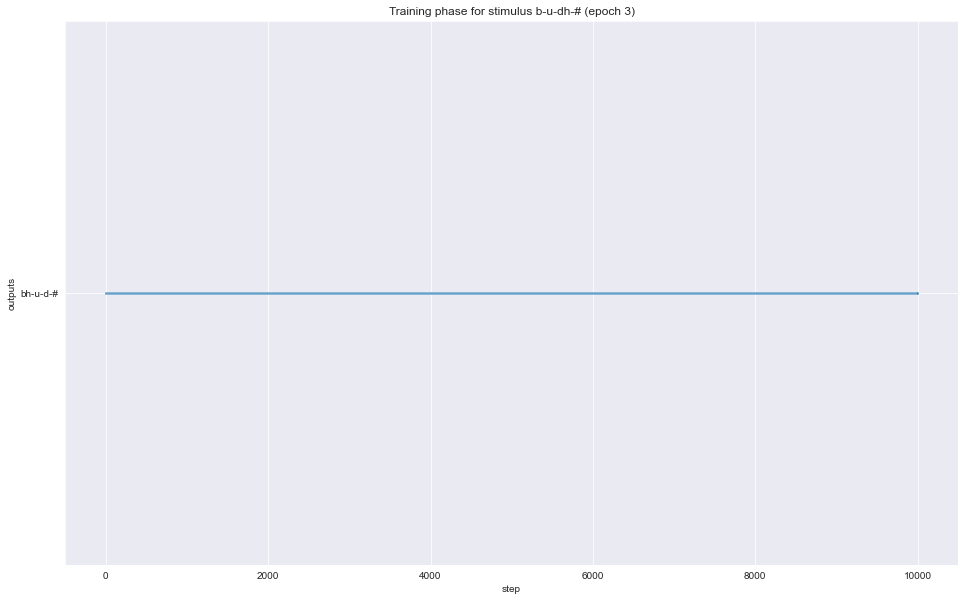

In [16]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(1, 3)

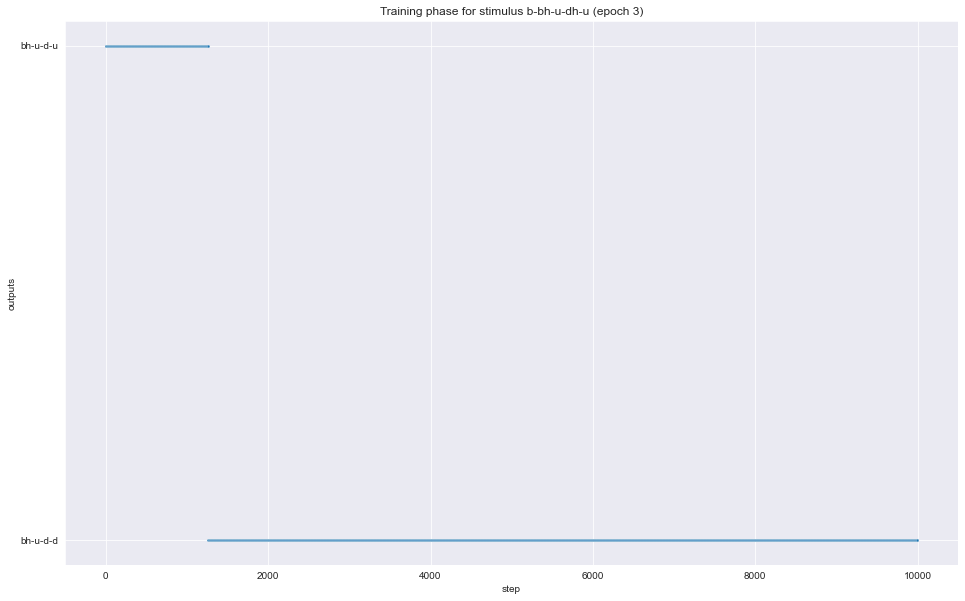

In [17]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(0, 3)

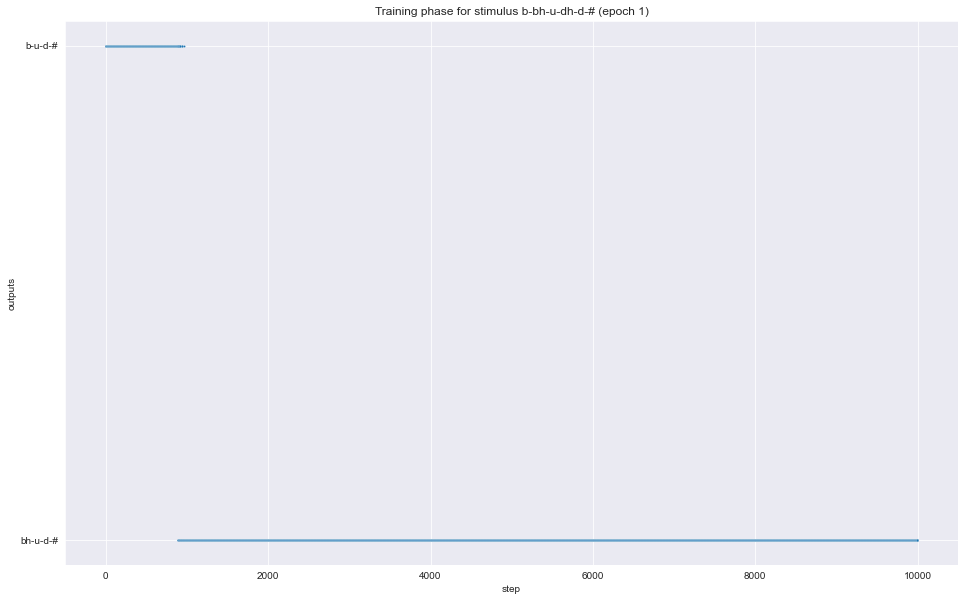

In [18]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(2, 1)

### Harmonies and Frequencies

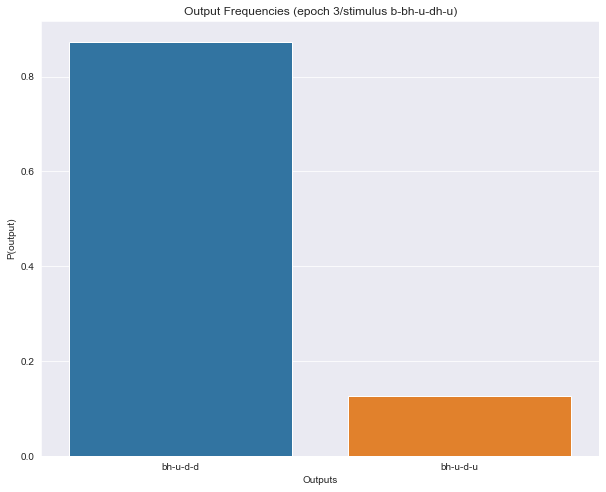

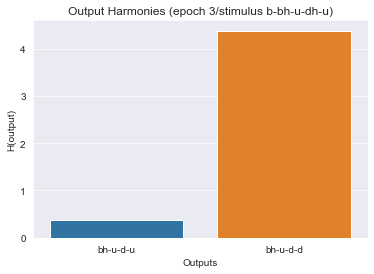

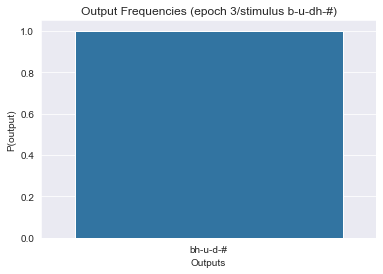

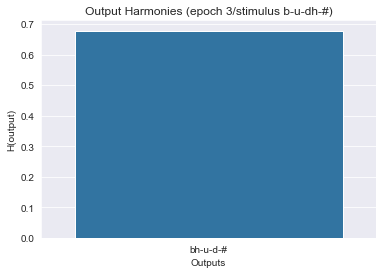

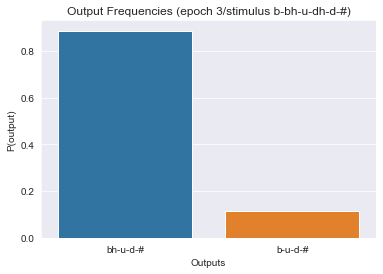

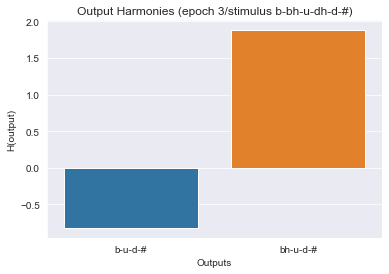

In [19]:
plt.figure(figsize=(10,8))
df = p.plot_final_states(save=True)

### Harmony vs. Activation

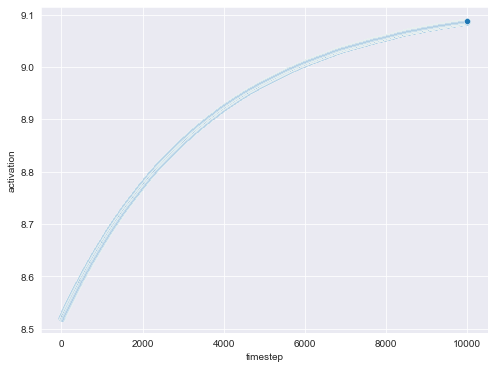

In [20]:
plt.figure(figsize=(8,6))
df = p.plot_act_stim(0,4, save=True)

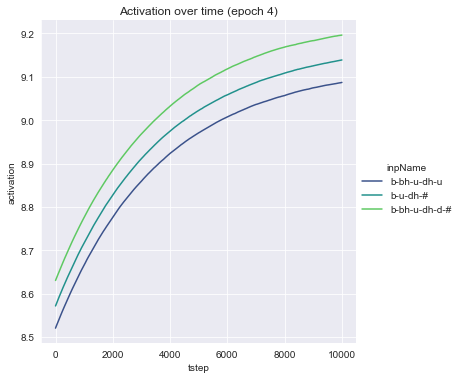

In [21]:
df = p.plot_input_tstep(4,what="activation")

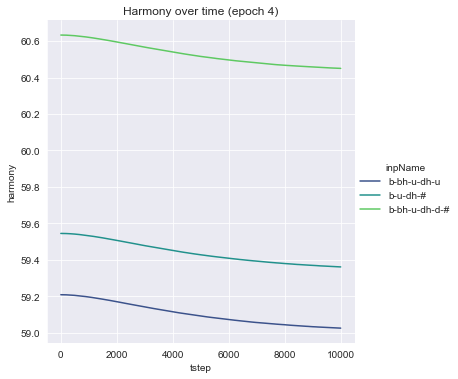

In [22]:
df = p.plot_input_tstep(4,what="harmony")
# Why???

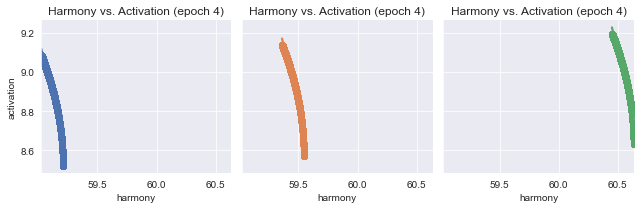

In [23]:
df = p.plot_input_tstep(4,what="regplot_facet")

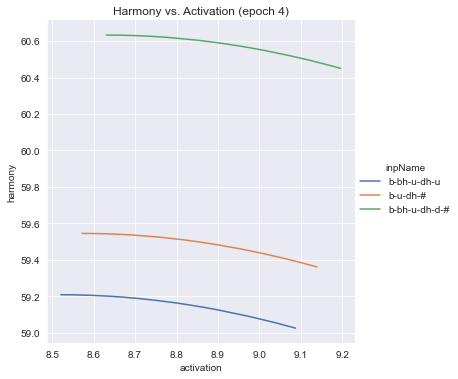

In [24]:
df = p.plot_input_tstep(4,what="regplot")

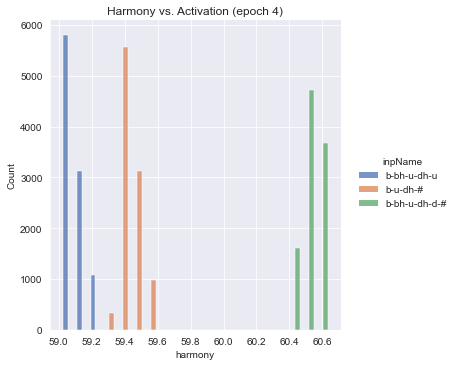

In [25]:
df = p.plot_input_tstep(4,what="harm_dist_inp")

## States update through time

In [26]:
data = p.data
c = data['C_trace']

In [27]:
# Input 0, epoch 4
mat = c[0, 4, i, :, :]
print(mat)
winner = ""
for i in range(mat.shape[1]):
    m = torch.argmax(mat[:,i])
    winner += fillers[m]
print(winner)

tensor([[0.5679, 0.4000, 0.4000, 0.4000],
        [0.5255, 0.4000, 0.4000, 0.4000],
        [0.4000, 0.5988, 0.4000, 0.4354],
        [0.4000, 0.4000, 0.5787, 0.4268],
        [0.4000, 0.4000, 0.3052, 0.3245],
        [0.4000, 0.4000, 0.4000, 0.4000]])
bhudu


step: 0 for input b-bh-u-dh-u 
Winner: bhudu


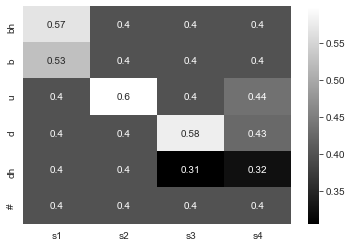

step: 2500 for input b-bh-u-dh-u 
Winner: bhudd


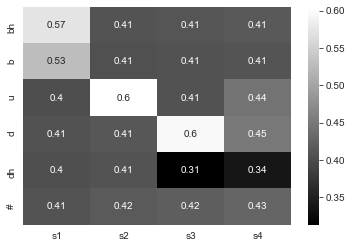

step: 5000 for input b-bh-u-dh-u 
Winner: bhudd


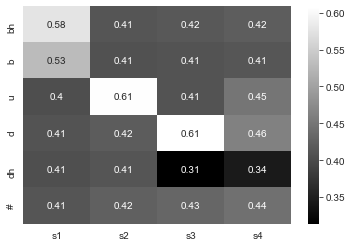

step: 7500 for input b-bh-u-dh-u 
Winner: bhudd


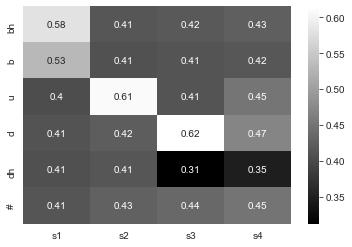

In [28]:
for i in range(0, 10000,2500):
    mat = c[0, 3, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    winner = ""
    for i in range(mat.shape[1]):
        m = torch.argmax(mat[:,i])
        winner += fillers[m]
    print(f"Winner: {winner}")
    sns.heatmap(df, annot=True, cmap="gray")
    plt.show()

step: 0 for input b-bh-u-dh-u 
Winner: bhudu


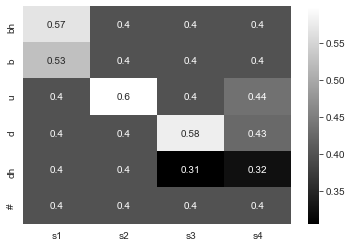

step: 2500 for input b-bh-u-dh-u 
Winner: bhudd


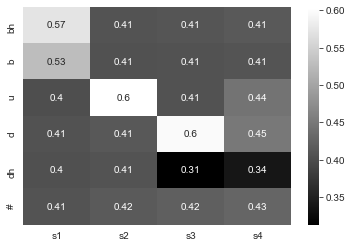

step: 5000 for input b-bh-u-dh-u 
Winner: bhudd


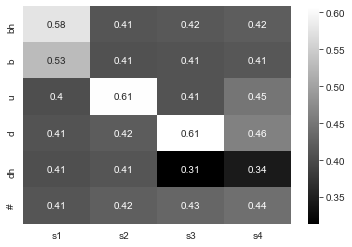

step: 7500 for input b-bh-u-dh-u 
Winner: bhudd


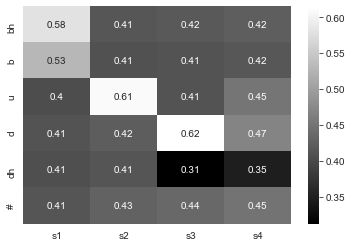

In [29]:
for i in range(0, 10000,2500):
    mat = c[0, 4, i, :, :]
    df = pd.DataFrame(mat.numpy(), index=fillers, columns=roles)
    print(f"step: {i} for input {p.inputNames[0]} ")
    winner = ""
    for i in range(mat.shape[1]):
        m = torch.argmax(mat[:,i])
        winner += fillers[m]
    print(f"Winner: {winner}")
    sns.heatmap(df, annot=True, cmap="gray")
    plt.show()